# Project 2 : Two dimentional Ising model

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
%reload_ext autoreload

In [24]:
import pickle
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as skms
import sklearn.linear_model as skl
import sklearn.metrics as skm
import tqdm
import copy
import time
from IPython.display import display

%matplotlib inline

sns.set(color_codes=True)

import algorithms
from classification import LogisticRegression

In [25]:
cwd = os.getcwd()
filenames = glob.glob(os.path.join(cwd, 'files*'))

In [26]:
label_filename = "/home/hanna/project2/files/Ising2DFM_reSample_L40_T=All_labels.pkl"

# Read in the labels
with open(label_filename, "rb") as f:
    labels = pickle.load(f)

dat_filename = "/home/hanna/project2/files/Ising2DFM_reSample_L40_T=All.pkl"
    
# Read in the corresponding configurations
with open(dat_filename, "rb") as f:
    data = np.unpackbits(pickle.load(f)).reshape(-1, 1600).astype("int")

# Set spin-down to -1
data[data == 0] = -1

In [27]:
data.shape

(160000, 1600)

In [28]:
# Set up slices of the dataset
ordered = slice(0, 70000)
critical = slice(70000, 100000)
disordered = slice(100000, 160000)

X = np.concatenate((data[ordered], data[disordered]))
Y = np.concatenate((labels[ordered], labels[disordered]))

In [29]:
labels[ordered].shape, labels[disordered].shape

((70000,), (60000,))

In [30]:
data[ordered].shape, data[disordered].shape

((70000, 1600), (60000, 1600))

In [31]:
Y.shape

(130000,)

In [32]:
data[disordered]

array([[ 1,  1, -1, ..., -1,  1,  1],
       [ 1,  1, -1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       ..., 
       [ 1,  1,  1, ...,  1,  1, -1],
       [ 1,  1,  1, ...,  1, -1, -1],
       [ 1,  1,  1, ...,  1, -1, -1]])

In [33]:
X.shape

(130000, 1600)

In [34]:
X_train, X_test, y_train, y_test = skms.train_test_split(X,Y, test_size = 0.333)

In [35]:
#from utils import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, Y, split_size=0.3, random_state=0)

In [36]:
# Testing that y_test and train contain both label 
y_train, y_test

(array([0, 0, 0, ..., 1, 0, 1]), array([1, 1, 1, ..., 1, 0, 0]))

# Running different cases of Logistic Regression

In [41]:
from classificationNew import LogisticRegression

In [49]:
eta = [0.0001, 0.001, 0.01, 0.1]
lmd = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]

results = []
epoch_costs = []

for e in eta:
    for l in lmd:
        a = LogisticRegression(eta = e,
                               random_state = 0, 
                               shuffle = True,
                               batch_size = 10, 
                               epochs=10, 
                               penalty = "l1",
                               lmd = l, 
                               key = "sigmoid")
                            
        log = a.fit(X_train, y_train)
        epoch_costs.append(log.epochCost)
        score = log.predict(X_test)
        acc = np.sum(score == y_test)/len(score)
        results.append(acc)
        print(" For eta %.4f  and lmd = %.4f the accuracy is %f " %(e, l, acc))
    print("----------------------------")

 For eta 0.0001  and lmd = 0.0001 the accuracy is 0.687249 
 For eta 0.0001  and lmd = 0.0010 the accuracy is 0.685770 
 For eta 0.0001  and lmd = 0.0100 the accuracy is 0.656664 
 For eta 0.0001  and lmd = 0.1000 the accuracy is 0.539848 
 For eta 0.0001  and lmd = 1.0000 the accuracy is 0.312312 
 For eta 0.0001  and lmd = 10.0000 the accuracy is 0.512035 
----------------------------
 For eta 0.0010  and lmd = 0.0001 the accuracy is 0.469762 
 For eta 0.0010  and lmd = 0.0010 the accuracy is 0.469323 
 For eta 0.0010  and lmd = 0.0100 the accuracy is 0.464403 
 For eta 0.0010  and lmd = 0.1000 the accuracy is 0.428898 
 For eta 0.0010  and lmd = 1.0000 the accuracy is 0.287156 
 For eta 0.0010  and lmd = 10.0000 the accuracy is 0.367290 
----------------------------
 For eta 0.0100  and lmd = 0.0001 the accuracy is 0.472395 
 For eta 0.0100  and lmd = 0.0010 the accuracy is 0.473296 
 For eta 0.0100  and lmd = 0.0100 the accuracy is 0.470409 
 For eta 0.0100  and lmd = 0.1000 the ac

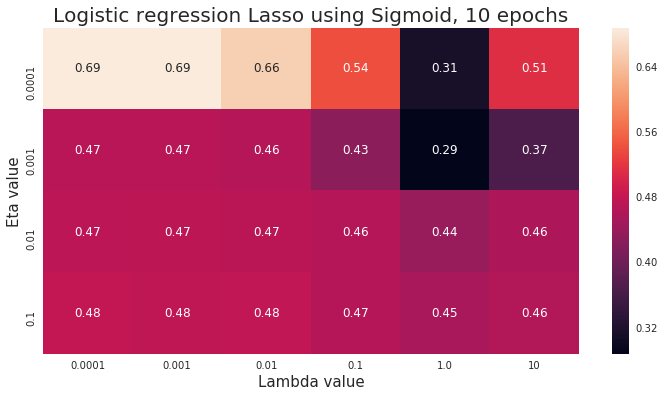

In [51]:
m = np.array(results).reshape((len(eta), len(lmd)))

plt.figure(figsize=(12,6))
ax = sns.heatmap(m, annot = True, xticklabels=lmd, yticklabels=eta)
ax.set_title("Logistic regression Lasso using Sigmoid, 10 epochs", fontsize = 20)
ax.set_xlabel("Lambda value", fontsize = 15)
ax.set_ylabel("Eta value", fontsize = 15) #
plt.savefig("./results/figures/Logisticregression_Lasso_sigmoid_10.png")

In [ ]:
np.shape(epoch_costs[0])

In [ ]:
"""best_fit = epoch_costs
epochs = np.arange(100)

plt.figure(figsize = (10,6))
plt.title("Costfunction for LASSO" ,fontsize = 20)

for i in range(len(best_fit)):
    plt.plot(epochs, best_fit[i], label = str(i))

plt.xlabel("Epoch", fontsize = 15)
plt.ylabel("Cost", fontsize = 15)
plt.legend()
plt.savefig("costfunc_all_lasso_sigmoid_50.png")"""

In [ ]:
"""
best_fit = epoch_costs[0]
epochs = np.arange(100)

plt.figure(figsize = (10,6))
plt.title("Costfunction for LASSO" ,fontsize = 20)

plt.plot(epochs, best_fit, label = "lmd = 0.0001, eta = 0.0001")
plt.xlabel("Epoch", fontsize = 15)
plt.ylabel("Cost", fontsize = 15)
plt.legend()
plt.savefig("costfunc_lasso_sigmoid_epochs100.png")"""

In [43]:
eta = [0.0001, 0.001, 0.01, 0.1]
lmd = [0]

results = []
epoch_costs = []

for e in eta:
    for l in lmd:
        a = LogisticRegression(eta = e,
                               random_state = 0, 
                               shuffle = True,
                               batch_size = 10, 
                               epochs=50, 
                               penalty = "l1",
                               lmd = l, 
                               key = "sigmoid")
                            
        log = a.fit(X_train, y_train)
        epoch_costs.append(log.epochCost)
        score = log.predict(X_test)
        acc = np.sum(score == y_test)/len(score)
        results.append(acc)
        print(acc)

0.446777546778
0.464148764149
0.469762069762
0.469461769462


# Trying different output functions

In [53]:
eta = [0.0001, 0.001, 0.01, 0.1]
lmd = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]

results = []
epoch_costs = []
# windows + l

for e in eta:
    for l in lmd:
        a = LogisticRegression(eta = e,
                               random_state = 0, 
                               shuffle = True,
                               batch_size = 10, 
                               epochs=50, 
                               penalty = "l1",
                               lmd = l, 
                               key = "LReLu",
                               alpha = 0.0001)
                            
        log = a.fit(X_train, y_train)
        epoch_costs.append(log.epochCost)
        score = log.predict(X_test)
        acc = np.sum(score == y_test)/len(score)
        print("lmd: " + str(l) + "  eta: " + str(e) + " accuracy  " + str(acc))
        results.append(acc)

/home/hanna/project2/classificationNew.py:109: RuntimeWarning: invalid value encountered in log
  cost = -batchY.dot(np.log(output + 1e-8)) - ((1 - batchY).dot(np.log(1 - output + 1e-8) )) + cterm


lmd: 0.0001  eta: 0.0001 accuracy  0.538577038577
lmd: 0.001  eta: 0.0001 accuracy  0.538577038577
lmd: 0.01  eta: 0.0001 accuracy  0.538369138369
lmd: 0.1  eta: 0.0001 accuracy  0.538369138369
lmd: 1.0  eta: 0.0001 accuracy  0.538369138369
lmd: 10  eta: 0.0001 accuracy  0.538369138369


/home/hanna/project2/classificationNew.py:118: RuntimeWarning: invalid value encountered in greater_equal
  score = np.sum(np.where(test >= 0.5, 1, 0) == batchY)/len(output)
/home/hanna/project2/classificationNew.py:145: RuntimeWarning: invalid value encountered in less_equal
  Z_out[np.where(Xw <= 0)] = self.alpha * Xw[np.where(Xw <= 0)]
/home/hanna/project2/classificationNew.py:164: RuntimeWarning: invalid value encountered in greater_equal
  return np.where(new >= 0.5, 1, 0)


lmd: 0.0001  eta: 0.001 accuracy  0.461630861631
lmd: 0.001  eta: 0.001 accuracy  0.461630861631
lmd: 0.01  eta: 0.001 accuracy  0.461630861631


/home/hanna/project2/classificationNew.py:116: RuntimeWarning: invalid value encountered in add
  net_input = np.dot(batchX, self.w_) + self.b_


lmd: 0.1  eta: 0.001 accuracy  0.461630861631
lmd: 1.0  eta: 0.001 accuracy  0.461630861631
lmd: 10  eta: 0.001 accuracy  0.461630861631
lmd: 0.0001  eta: 0.01 accuracy  0.461630861631
lmd: 0.001  eta: 0.01 accuracy  0.461630861631
lmd: 0.01  eta: 0.01 accuracy  0.461630861631
lmd: 0.1  eta: 0.01 accuracy  0.461630861631
lmd: 1.0  eta: 0.01 accuracy  0.461630861631
lmd: 10  eta: 0.01 accuracy  0.461630861631
lmd: 0.0001  eta: 0.1 accuracy  0.461630861631
lmd: 0.001  eta: 0.1 accuracy  0.461630861631


/home/hanna/project2/classificationNew.py:93: RuntimeWarning: invalid value encountered in add
  net_input = np.dot(batchX, self.w_) + self.b_


lmd: 0.01  eta: 0.1 accuracy  0.461630861631
lmd: 0.1  eta: 0.1 accuracy  0.461630861631
lmd: 1.0  eta: 0.1 accuracy  0.461630861631
lmd: 10  eta: 0.1 accuracy  0.461630861631


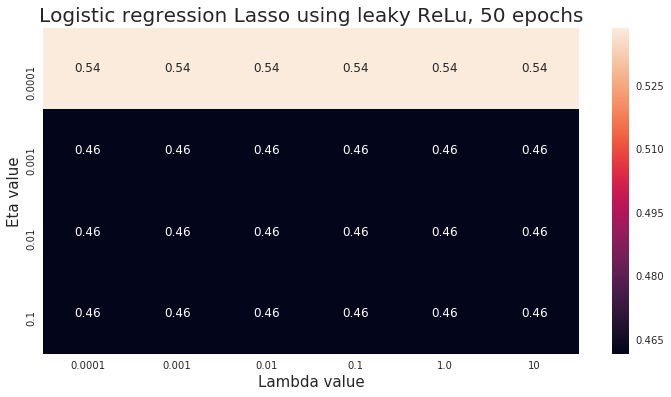

In [55]:
m = np.array(results).reshape((len(eta), len(lmd)))

plt.figure(figsize=(12,6))
ax = sns.heatmap(m, annot = True, xticklabels=lmd, yticklabels=eta)
ax.set_title("Logistic regression Lasso using leaky ReLu, 50 epochs", fontsize = 20)
ax.set_xlabel("Lambda value", fontsize = 15)
ax.set_ylabel("Eta value", fontsize = 15) #
plt.savefig("./results/figures/Logisticregression_Lasso_LRELU_50.png")

In [ ]:
eta = [0.0001, 0.001, 0.01, 0.1]
lmd = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]

results = []
epoch_costs = []

for e in eta:
    for l in lmd:
        a = LogisticRegression(eta = e,
                               random_state = 0, 
                               shuffle = True,
                               batch_size = 10, 
                               epochs=50, 
                               penalty = "l1",
                               lmd = l, 
                               key = "elu", 
                               alpha = 0.0001)
                            
        log = a.fit(X_train, y_train)
        epoch_costs.append(log.epochCost)
        score = log.predict(X_test)
        acc = np.sum(score == y_test)/len(score)
        print("lmd: " + str(l) + "  eta: " + str(e) + " accuracy  " + str(acc))
        results.append(acc)

lmd: 0.0001  eta: 0.0001 accuracy  0.538577038577
lmd: 0.001  eta: 0.0001 accuracy  0.538577038577
lmd: 0.01  eta: 0.0001 accuracy  0.538369138369
lmd: 0.1  eta: 0.0001 accuracy  0.538369138369
lmd: 1.0  eta: 0.0001 accuracy  0.538369138369
lmd: 10  eta: 0.0001 accuracy  0.538369138369


/home/hanna/project2/classificationNew.py:149: RuntimeWarning: invalid value encountered in less_equal
  Z_out[np.where(Xw <= 0)] = self.alpha *(np.exp( Xw[np.where(Xw <= 0)]) - 1)


lmd: 0.0001  eta: 0.001 accuracy  0.461630861631
lmd: 0.001  eta: 0.001 accuracy  0.461630861631
lmd: 0.01  eta: 0.001 accuracy  0.461630861631


In [ ]:
m = np.array(results).reshape((len(eta), len(lmd)))

plt.figure(figsize=(12,6))
ax = sns.heatmap(m, annot = True, xticklabels=lmd, yticklabels=eta)
ax.set_title("Logistic regression Lasso using elu, 50 epoch", fontsize = 20)
ax.set_xlabel("Lambda value", fontsize = 15)
ax.set_ylabel("Eta value", fontsize = 15)
plt.savefig("./results/figures/Logisticregression_Lasso_ELU_50.png")

# Ridge regression

In [ ]:
eta = [0.0001, 0.001, 0.01, 0.1]
lmd = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]

results = []

# windows + l

for e in eta:
    for l in lmd:
        a = LogisticRegression(eta = e,
                               random_state = 0, 
                               shuffle = True,
                               batch_size = 10, 
                               epochs=50, 
                               penalty = "l2",
                               lmd = l, 
                               tolerance=1e-14, 
                               key = "sigmoid", 
                               alpha = 0.01)
                            
        log = a.fit(X_train, y_train)
        score = log.predict(X_test)
        acc = np.sum(score == y_test)/len(score)
        #print("lmd: " + str(l) + "  eta: " + str(e) + " accuracy  " + str(acc))
        results.append(acc)

In [ ]:
m = np.array(results).reshape((len(eta), len(lmd)))

plt.figure(figsize=(12,6))
ax = sns.heatmap(m, annot = True, xticklabels=lmd, yticklabels=eta)
ax.set_title("Logistic regression Ridge using Sigmoid", fontsize = 20)
ax.set_xlabel("Lambda value", fontsize = 15)
ax.set_ylabel("Eta value", fontsize = 15) #
#plt.savefig("./results/figures/Logisticregression_Ridge_sigmoid_50.png")

# Comparing this to sci-kit learn

In [ ]:
# Case ridge for the best? optimizer.
clf = skl.LogisticRegression(penalty='l2')
clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

In [ ]:
# Should be similar to lasso with the best optimizer.
clf = skl.LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)